### Import packages

본 파이썬 노트북 파일에서 사용할 패키지를 임포트 합니다.

numpy, pandas, tensorflow를 임포트할 것입니다.

만약 패키지가 설치되어있지 않다면 아래 코드를 코드 셀에서 실행해주세요.

```python
!pip install numpy
!pip install pandas
!pip install tensorflow==2.0
```

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# tensorflow version 확인
tf.__version__

'2.0.0'

### Load data

데이터를 불러옵니다.

본 파이썬 노트북 파일 기준 디렉토리 안에 'data' 이름의 폴더가 위치해야 하고

이 안에 'word_vec.npy' 파일과 'nm_review(score_balanced).tsv' 파일이 있어야 합니다.

'word_vec.npy' 파일은 리뷰 데이터를 Fasttext로 word embedding한 npy 형식 데이터 파일입니다.

'nm_review(score_balanced).tsv' 파일은 리뷰와 평점이 있는 tsv 형식 데이터 파일입니다.

In [3]:
path = './data/'

# 'word_vec.npy' 파일을 불러와 doc 변수에 할당합니다. 
doc = np.load(path+'word_vec.npy', allow_pickle=True)  

# 'nm_review(score_balanced).tsv' 파일을 불러와 df 변수에 할당합니다.
df = df = pd.read_csv(path+'nm_review(score_balanced).tsv', delimiter='\t', index_col=0)

'word_vec.npy' 파일에 있는 단어는 다음과 같은 형태로 좌표값을 가지고 있습니다.

In [5]:
doc[0][0]

array([-0.25383863,  1.8346193 , -0.40305537,  1.698885  , -0.982371  ,
       -0.6023514 , -0.5963207 ,  0.5519625 ,  2.3922281 ,  0.9792969 ,
        0.3598242 , -1.2430675 ,  0.07758226, -1.0470091 , -0.03433892,
        0.69567513,  0.1326249 , -0.1676411 , -1.5439154 , -1.9425869 ,
        0.11234223, -1.0791332 ,  0.03264725, -0.841432  ,  0.693265  ,
       -0.10277614,  0.07169957, -0.8718886 , -1.1446017 ,  0.8203075 ,
        2.356588  ,  0.74660057,  0.0391999 , -0.8811774 ,  0.7354779 ,
        0.79156345, -0.04052317, -1.1106507 ,  1.2050041 ,  1.7165027 ,
       -0.07859013, -0.10018837, -0.60930854, -1.8627307 ,  0.8109545 ,
       -0.28432336,  0.5269071 ,  0.3928959 ,  0.7594724 , -0.03083267,
       -0.31821048, -0.09510605,  0.04765771,  1.7479426 ,  0.63428205,
        1.2642165 ,  0.0350229 , -0.06357922, -0.87908494,  0.1961193 ,
       -0.16039726,  0.8288496 ,  0.8738681 ,  0.08258398, -0.17514278,
        0.24540766, -1.7460033 , -0.64451504,  0.43556786, -1.27

'nm_review(score_balanced).tsv' 파일은 다음과 같은 구조를 가지고 있습니다.

In [7]:
df.head()

,code,uid,datetime,score,review,sympathy,notsympathy
0,167699,15108707,2019.01.11 05:36,1,우리나라 영화계는 반일이랑 518 없으면 영화를 만들지를 못해요....,10,19
1,167699,15112721,2019.01.12 09:42,4,어제 메박가서 보고왔는데 솔직히 지루했습니다. 내용전개도 스토리도 특별하지 않구요....,1,11
2,167699,15119773,2019.01.13 16:08,2,보지마라 존나 지루하고 잔인,2,12
3,167651,15189096,2019.01.30 14:48,10,지친 하루를 보냈는데 오랫만에 웃어보았어요.^^,1,0
4,164172,15405102,2019.03.12 04:52,8,재밋게 보았음 그냥 기분이 좋아지는 코믹물,5,3


doc 변수는 numpy array 타입이고 df 변수는 pandas dataframe 타입입니다.

변수의 수와 컬럼 수를 알고 싶으면 shape 함수를 이용합니다.

In [9]:
print(f'type(doc): {type(doc)}')
print(f'type(df): {type(df)}')
print(f'doc.shape: {doc.shape}')
print(f'df.shape: {df.shape}')

type(doc): <class 'numpy.ndarray'>
type(df): <class 'pandas.core.frame.DataFrame'>
doc.shape: (86750,)
df.shape: (86750, 7)


### Set random seed

랜덤시드를 설정합니다.

여기서는 42번으로 하겠습니다.

In [10]:
# 랜덤시드 설정
import random
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Split dataset

데이터셋을 train set과 test set으로 나눕니다.

scikit-learn의 train_test_split 모듈을 이용합니다.

scikit-learn이 설치되어있지 않다면 아래 코드를 코드 셀에서 실행해주세요.

```python
!pip install scikit-learn
```

train_test_split 함수에는 test_size와 shuffle, stratify라는 인자가 있습니다.

test_size는 train set과 test set의 비율을 얼마로 할 것인지를 나타냅니다.

0.2로 설정하면 train set과 test set 비율이 8 : 2가 됩니다.

shuffle은 data set을 나누기 전에 row 기준으로 데이터를 섞을 것인지를 나타냅니다.

stratify는 data set을 나눌때 비율을 동일하게 유지할 변수를 나타냅니다.

여기서는 평점 기준으로 1점부터 10점까지 각 점수에 대한 train set과 test set을 동일하게 유지하기 위해 df의 score를 기준으로 잡습니다.

In [11]:
from sklearn.model_selection import train_test_split

# train : test = 8 : 2
x_train, x_test, y_train, y_test = train_test_split(doc, df['score'], test_size=0.2, shuffle=True, stratify=df['score'])

print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape : {y_test.shape}')

x_train.shape: (69400,)
x_test.shape : (17350,)
y_train.shape: (69400,)
y_test.shape : (17350,)


label(y)이 현재 pandas의 series 타입입니다. (dataframe에서 하나의 column을 선택하면 series 타입이 됩니다.)

나중에 keras에서 데이터를 투입하려면 타입을 바꿔줄 필요가 있습니다. numpy array 형식으로 변환합니다.

In [12]:
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
print(f'y_train_arr.shape: {y_train_arr.shape}, type: {type(y_train_arr)}')

y_train_arr.shape: (69400,), type: <class 'numpy.ndarray'>


### Pad sequences

현재 feature는 영화 리뷰가 단어가 np.array로 리스트에 담긴 형태입니다.

리뷰마다 단어의 갯수가 다르기 때문에 리스트의 크기가 제각각입니다.

나중에 keras 모델에 투입하려면 아 크기를 맞춰 줄 필요가 있습니다.

keras에 있는 pad_sequences 기능을 이용해서 이 크기를 맞춰줍니다.

In [13]:
maxlen = max([len(x) for x in doc])  # doc 안에 있는 리스트 크기 중 가장 큰 리스트의 수를 maxlen 변수에 할당합니다.

In [15]:
from tensorflow.keras.preprocessing import sequence

x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen, dtype='float32', padding='post')
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen, dtype='float32', padding='post')
print('x_train_seq shape:', x_train_seq.shape)
print('x_test_seq shape:', x_test_seq.shape)

x_train_seq shape: (69400, 60, 128)
x_test_seq shape: (17350, 60, 128)


### Feature scaling

모델을 훈련할 때 투입되는 데이터는 0에서 1 사이의 크기를 가지는 것이 좋습니다.

scikit-learn의 MInMaxScaler를 이용하면 데이터의 크기를 0에서 1 사이로 줄이는 작업을 쉽게 할 수 있습니다.

여기서는 Fasttext라는 임베딩 작업을 실시했기 때문에 음수 값이 의미를 갖을 수 있습니다. 그래서 -1에서 1 사이로 적합했습니다.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])
for idx, item in enumerate(x_train_seq):
    x_train_seq[idx] = mms.transform(item)
for idx, item in enumerate(x_test_seq):
    x_test_seq[idx] = mms.transform(item)

### Label encoding

label인 평점 데이터가 1점부터 10점 사이의 정수이므로 one-hot encoding 했습니다.

In [17]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encoder
enc = OneHotEncoder(categories='auto')
enc.fit(np.array(list(set(y_test))).reshape(-1, 1))
print(enc.get_feature_names())

# one-hot encoding
y_train_enc = enc.transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test_enc = enc.transform(np.array(y_test).reshape(-1, 1)).toarray()

['x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_5' 'x0_6' 'x0_7' 'x0_8' 'x0_9' 'x0_10']


### Keras modeling

모델링을 진행하기 전에 커스텀하여 사용할 레이어를 정의했습니다.

def 키워드를 사용하면 커스텀 함수를 만들 수 있습니다.

이것으로 사용할 CNN 레이어와 Bahdanau Attention 레이어를 정의합니다.

In [18]:
# CNN layer
def conv_block(x, filter_nums, filter_sizes):
    """A convolution block"""
    conv_blocks = []

    for fn, fs in zip(filter_nums, filter_sizes):
        conv = tf.keras.layers.Conv1D(filters=fn,
                                      kernel_size=fs,
                                      padding='same',
                                      activation=tf.nn.relu,
                                      strides=1)(x)
        #conv = layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    return conv_blocks


# Attention layer
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Bahdanau attention과 모델 구조는 https://wikidocs.net/48920 를 참고해서 만들었습니다.

In [19]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Attention, Concatenate, Dropout, BatchNormalization

def create_model():
    with tf.init_scope():
        # shape [batch_size, max_tokens=60, dim=128]
        inputs = Input(shape=(60, 128))

        # CNN
        blocks = conv_block(inputs, 
                            filter_nums=(64, 64, 64, 64),  # 각 필터 종류마다 64개의 필터 수를 만듦
                            filter_sizes=(1, 2, 3, 4))  # 필터 사이즈 종류는 1, 2, 3, 4 4가지이며 이것은 n-gram의 n을 의미
        cnn_outputs = Concatenate()(blocks)  # 서로 나눠진 매트릭스를 결합합니다. (60, 256)
        cnn_outputs = Dropout(0.3)(cnn_outputs)

        # Bi-LSTM
        lstm_outputs, fw_h, fw_c, bw_h, bw_c = Bidirectional(
            LSTM(64,  # output units을 64로 합니다. bidirectional이 있기 때문에 128 units의 outputs이 됩니다.
                 dropout=0.3,
                 return_sequences=True,  # RNN 계열에서는 매 sequence마다 출력이 나오게 할 수 있습니다.
                 return_state=True,  # LSTM의 hidden state와 cell state를 출력하게 합니다.
                 recurrent_activation=tf.nn.relu,
                 recurrent_initializer='glorot_uniform'))(cnn_outputs)

        state_h = Concatenate()([fw_h, bw_h]) # 은닉 상태
        # state_c = Concatenate()([fw_c, bw_c]) # 셀 상태

        # Attention
        context_vector, attention_weights = BahdanauAttention(128)(lstm_outputs, state_h)  # Bahdanau attention layer
        attn_outputs = BatchNormalization(epsilon=1e-6)(context_vector)  # 정규화 과정을 한번 거칩니다.

        # outputs
        # 선형 레이어를 한번 거치도록 했습니다.
        outputs = tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_initializer='glorot_uniform')(attn_outputs)
        outputs = tf.keras.layers.Dropout(0.2, seed=42)(outputs)
        outputs = tf.keras.layers.Dense(10, activation=tf.nn.softmax,
                                        kernel_initializer='glorot_uniform',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.04))(outputs)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [20]:
model = create_model()  # 모델을 생성합니다. 모델을 초기화 하고 싶을때에도 이 코드 셀을 돌리면 됩니다.

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 128)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 64)       24640       input_1[0][0]                    
______________________________________________________________________________________________

loss 함수와 optimizer를 정의합니다.

In [23]:
# losses and optimizer
from tensorflow.keras import optimizers

# def custom_loss(y_true, y_pred):
#     return tf.reduce_mean(tf.math.squared_difference(y_true - y_pred))

def custom_mae(y_true, y_pred):  # 회귀 모델과 비교하기 위해 커스텀 MAE를 제작했습니다.
    loss = tf.keras.losses.MAE(
        (tf.reduce_sum(y_true*tf.constant(list(range(1, 11)), dtype=tf.float32), axis=1)-1)/9,
        (tf.reduce_sum(y_pred*tf.constant(list(range(1, 11)), dtype=tf.float32), axis=1)-1)/9
    )
    return loss

Adam = optimizers.Adam(learning_rate=0.001, clipnorm=0.5)  # Adam optimizer
RMSprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipnorm=0.5)  # RMSprop optimizer

분류 문제이기 때문에 loss 함수로 categorical_crossentropy를 이용했습니다.

metrics는 loss와 별개로 모델의 성능을 보기 위한 지표를 설정할 수 있습니다. 여기서는 accracy와 앞서 설정했던 custom_mae를 사용합니다.

In [24]:
# model compile
model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy', custom_mae])

early stopping을 지정합니다.

early stopping은 학습 시 epoch을 길게 하더라도 모델의 성능이 개선되지 않으면 학습을 중지하는 기능입니다.

patience를 30으로 지정하면 epoch이 연속 30회가 지나도록 성능 개선이 이뤄지지 않으면 학습을 중단합니다.

In [36]:
# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

checkpoint를 지정합니다.

checkpoint는 학습 중 생성되는 중간 단계의 모델을 epoch 단위로 저장하는 역할을 합니다.

그러나 중간단계의 모든 모델을 저장할 필요는 없기 때문에 중간 단계 중 성능이 가장 좋았던 모델만 저장하도록 했습니다.

모델 저장 경로를 기준 디렉토리 안의 model 폴더 안의 ckpt 폴더로 했기 때문에 이 경로 안에 폴더를 생성해 두어야 합니다.

In [37]:
# checkpoint
cp = tf.keras.callbacks.ModelCheckpoint(
    './model/ckpt/cnn_bilstm_bahattn_cls.ckpt', monitor='val_loss', save_best_only=True, save_weights_only=True)

학습은 배치 사이즈 256에 epoch 횟수 1000으로 하여 진행했습니다.

train data set의 20%를 validation set으로 활용했습니다.

callbacks 인자에 앞서 지정한 early stopping과 checkpoint를 리스트에 넣어서 입력합니다.

학습중 나오는 히스토리를 history 변수에 저장해둡니다.

In [38]:
# learn
history = model.fit(x_train_seq, y_train_enc, batch_size=256, epochs=1000, validation_split=0.2, shuffle=True,
                    callbacks=[es, cp])

Train on 55520 samples, validate on 13880 samples
Epoch 1/1000
55520/55520 [==============================] - 295s 5ms/sample - loss: 2.3840 - accuracy: 0.1788 - custom_mae: 0.2390 - val_loss: 2.3330 - val_accuracy: 0.1012 - val_custom_mae: 0.2740
Epoch 2/1000
55520/55520 [==============================] - 278s 5ms/sample - loss: 1.9935 - accuracy: 0.2413 - custom_mae: 0.1944 - val_loss: 2.2558 - val_accuracy: 0.1347 - val_custom_mae: 0.2634
Epoch 3/1000
55520/55520 [==============================] - 289s 5ms/sample - loss: 1.9520 - accuracy: 0.2497 - custom_mae: 0.1879 - val_loss: 2.1344 - val_accuracy: 0.2238 - val_custom_mae: 0.2394
Epoch 4/1000
55520/55520 [==============================] - 283s 5ms/sample - loss: 1.9288 - accuracy: 0.2584 - custom_mae: 0.1836 - val_loss: 1.9965 - val_accuracy: 0.2579 - val_custom_mae: 0.2096
Epoch 5/1000
55520/55520 [==============================] - 286s 5ms/sample - loss: 1.9134 - accuracy: 0.2617 - custom_mae: 0.1811 - val_loss: 1.9186 - val_ac

Epoch 42/1000
55520/55520 [==============================] - 303s 5ms/sample - loss: 1.6964 - accuracy: 0.3444 - custom_mae: 0.1475 - val_loss: 1.9494 - val_accuracy: 0.2784 - val_custom_mae: 0.1726
Epoch 43/1000
55520/55520 [==============================] - 300s 5ms/sample - loss: 1.6884 - accuracy: 0.3468 - custom_mae: 0.1469 - val_loss: 1.9422 - val_accuracy: 0.2648 - val_custom_mae: 0.1767
Epoch 44/1000
55520/55520 [==============================] - 300s 5ms/sample - loss: 1.6886 - accuracy: 0.3494 - custom_mae: 0.1474 - val_loss: 1.9751 - val_accuracy: 0.2694 - val_custom_mae: 0.1732
Epoch 45/1000
55520/55520 [==============================] - 322s 6ms/sample - loss: 1.6842 - accuracy: 0.3485 - custom_mae: 0.1468 - val_loss: 1.9578 - val_accuracy: 0.2656 - val_custom_mae: 0.1762
Epoch 46/1000
55520/55520 [==============================] - 300s 5ms/sample - loss: 1.6741 - accuracy: 0.3532 - custom_mae: 0.1449 - val_loss: 1.9441 - val_accuracy: 0.2774 - val_custom_mae: 0.1736
Epoch

학습이 끝난 후 체크포인트에 저장된 모델을 불러옵니다.

In [46]:
# checkpoint load
model.load_weights('./model/ckpt/cnn_bilstm_bahattn_cls.ckpt')

history를 저장하는 부분입니다. 안해주셔도 무방합니다.

In [48]:
# history 저장
import pickle
history_dict = history.history
with open('./data/cnn_bilstm_bahattn_cls_hist.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

In [49]:
# history 불러오기
with open('./data/cnn_bilstm_bahattn_cls_hist.pkl', 'rb') as f:
    history_dict = pickle.load(f)

## Evaluation

모델의 성능을 test set을 이용해 평가합니다.

In [47]:
# 모델 평가
results = model.evaluate(x_test_seq, y_test_enc)
print('loss: {:.6f} - acc: {:.6f} - mae: {:.6f}'.format(*results))

17350/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss: 1.899936 - acc: 0.272853 - mae: 0.178736


history를 이용해서 모델의 학습되면서 loss값과 metrics 값이 변화된 형태를 살펴볼 수 있습니다.

matplotlib package가 필요하기 때문에 설치되어있지 않다면 아래 코드를 코드 셀에서 실행해주세요.

```python
!pip install matplotlib
```

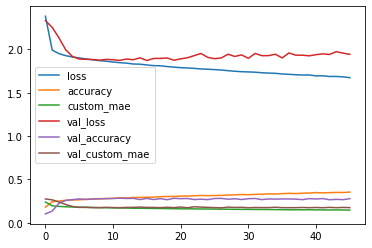

In [50]:
import matplotlib.pyplot as plt
for name, value in history_dict.items():
    plt.plot(value, label=name)

plt.legend()
plt.show()

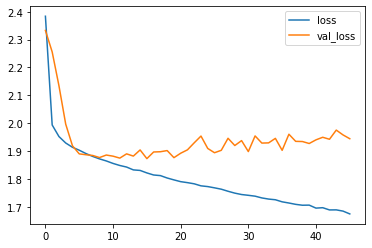

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Prediction

만들어진 모델로 특정 리뷰에 대한 감성 점수를 확인해보겠습니다.

리뷰 데이터는 string 형식이기 때문에 이를 word embedding으로 생성한 word vector로 변환해 주어야 합니다.

gensim 패키지 안에 있는 FastText 모듈을 이용해서 fasttext 모델을 불러옵니다.

gensim이 설치되어있지 않다면 아래 코드를 코드 셀에서 실행해주세요.

```python
!pip install gensim
```

In [7]:
import numpy as np
from gensim.models import FastText

ft_model = FastText.load('./model/fasttext_model')

텍스트를 word vector로 변환하기 전에 전처리 작업을 해주어야 합니다.

'hg_encoder.py' 파일 내에 전처리를 위한 함수를 만들어 놓았으니 이것을 이용합니다.

'hg_encoder.py' 파일은 본 파이썬 노트북 파일과 같은 경로에 위치하면 됩니다.

In [8]:
from hg_encoder import encode

def get_vector(query):
    query_ = encode(query)
    wv = ft_model.wv.get_vector(query_)
    return wv

min-max scale 작업도 똑같이 해줍니다.

text 변수에 평가할 리뷰를 입력합니다.

In [34]:
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])

text = '와 진짜 개노잼이네 ㅋㅋ거품이라는 것을 다시한번 깨달았다'
wvs = np.array([get_vector(t) for t in text.split(' ')])
wvs = mms.transform(wvs)
wvs_seq = sequence.pad_sequences(wvs.reshape(1, wvs.shape[0], -1), maxlen=60, dtype='float32', padding='post')

다음 코드를 돌리면 앞서 입력한 리뷰에 대한 점수를 볼 수 있습니다.

처음 나오는 결과값은 1점부터 10점까지 이 리뷰가 몇점에 해당하는지에 대한 확률을 나타냅니다.

argmax socre는 위의 확률 중 가장 높은 확률에 해당하는 점수입니다.

weighted sum score는 위의 확률에 해당하는 각각의 점수를 곱하여 모두 더해준 점수입니다.

In [35]:
test_pred = model.predict(wvs_seq)
print(model.predict(wvs_seq))
print('argmax score: {}'.format(np.argmax(test_pred) + 1))
print('weighted sum score: {:.6f}'.format(sum(test_pred[0]*range(1, 11))))

[[0.3870754  0.36912262 0.08834837 0.08348019 0.0346627  0.01517115
  0.00365747 0.00511626 0.00361804 0.00974773]]
argmax score: 1
weighted sum score: 2.185199


### Model save & load

학습된 모델을 저장하고 불러와 활용할 수 있습니다.

모델을 불러올 때에는 모델을 실행시키기 위해 필요한 패키지를 모두 불러와야 합니다.

```python
import numpy as np
import tensorflow as tf
```

원래 모델 자체를 저장할 수 있는데 오류가 발생해서 모델의 weights만 저장했습니다.

저장한 weigths를 불러오려면 모델을 학습시키기 전에 정의했던 모델을 다시 model 변수에 할당해야 합니다.

In [109]:
# Saving model weights. (어째서인지 모델 자체의 저장이 안됨)
model.save_weights('./model/cnn_bilstm_bahattn_cls', save_format = "tf")

In [6]:
# Loading model weights.
# 모델을 설계단계까지 진행 후 weight을 불러와야 한다.
model.load_weights('./model/cnn_bilstm_bahattn_cls')